# Q7.The Reuters Corpus

Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:

* you could cluster authors or documents and tell a story about what you find.
* you could look for common factors using PCA.
* you could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
* you could do anything else that strikes you as interesting with this data.

Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:

* Question: What question(s) are you trying to answer?
* Approach: What approach/statistical tool did you use to answer the questions?
* Results: What evidence/results did your approach provide to answer the questions? (E.g. any numbers, tables, figures as appropriate.)
* Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

## Question(s) - What questions are you trying to answer?
1. What are the predominant topics present within the corpus of documents?
2. Which author(s) should you refer to for a specific topic?

In [20]:
# import statements
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer

nltk.download('punkt') # for tokenizing

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manideeptelukuntla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Reading the data from a directory

In [21]:
# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("data/ReutersC50/C50test")

## Approach

### Data Pre-processing

#### Tokenization, Handling Stop Words and Stemming

* Tokenized each document in train_texts using word_tokenize() 
* Certain stopwords were not addressed by the nltk.corpus.stopwords library. To manage these stopwords more efficiently, we utilized a text file sourced from GitHub.
* Used PorterStemmer() for stemming

In [23]:
import pandas as pd

# Reading in the stopwords.txt file sourced from github
df = pd.read_csv('stopwords.txt', delimiter="\n", header=None, names=['stop_words'])
stop_words_list = list(df['stop_words'].values)

In [25]:
# Tokenize, remove stopwords, and keep words with more than 3 characters
texts = []
for doc in train_texts:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words_list and len(word) > 3]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    texts.append(stemmed_tokens)

#### Feature Extraction
* converting each document into a bag-of-words representation

In [26]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### Modeling
* Here we are doing Topic modeling which is an unsupervised text mining task that takes a corpus of documents and discovers abstract topics within that corpus. The input to a topic model is a collection of documents, and the output is a list of topics that defines words for each topic as well as assignment proportions of each topic in a document. 
* In our case we are using Latent Dirichlet Allocation (LDA), one of the most popular topic modeling techniques, tries to view a document as a collection of topics and a topic as a collection of words. Under the hood LDA works in the following way:
    * **Initialization:** LDA begins by making a random guess about which words belong to which topics.
    * **Refinement:** LDA then goes through each document and reassigns various words to topics based on two ideas:
        * How prevalent is that word across topics?
        * How prevalent are topics in that particular document?
* We used coherence scores and perplexity to figure out the right number of passes for LDA Model

In [27]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

NUM_TOPICS = 10

# Lists to store results
pass_values = list(range(1, 51))
coherence_values = []
perplexity_values = []

# Iterate over different pass values
for num_passes in pass_values:
    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=num_passes, random_state=42)
    
    # Calculate perplexity and coherence
    perplexity = lda_model.log_perplexity(corpus)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    # Append results to lists
    perplexity_values.append(perplexity)
    coherence_values.append(coherence)

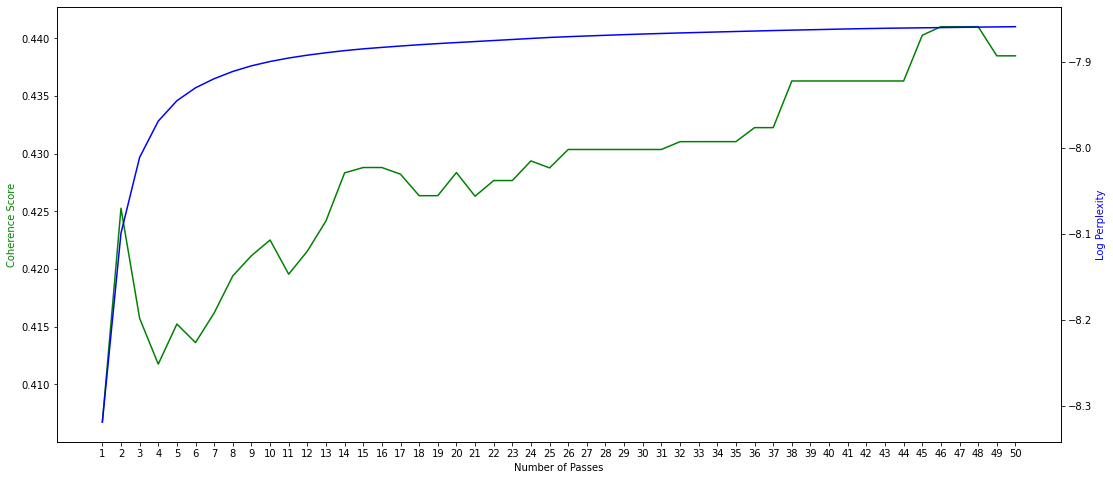

In [28]:
# Plot results
fig, ax1 = plt.subplots(figsize=(18, 8))

# Twin the axes
ax2 = ax1.twinx()

# Plot data
ax1.plot(pass_values, coherence_values, 'g-')
ax2.plot(pass_values, perplexity_values, 'b-')

# Set the y axis labels
ax1.set_ylabel('Coherence Score', color='g')
ax2.set_ylabel('Log Perplexity', color='b')

# Set x axis label
ax1.set_xlabel('Number of Passes')

ax1.set_xticks(np.arange(1, 51, 1))

# Show the plot
plt.show()

* From the graph, we identified the optimal number of passes to be 48 by noting where the improvements began to level off. We made this determination by testing a range of values and comparing the results using both coherence score and perplexity.
* Given the computational constraints, we opted for fewer passes, even though additional passes might yield improved results.

In [29]:
# Optimum model
lda_model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=48, random_state=42)

## Topic Interpretation
* This answers the question: 1. What are the predominant topics present within the corpus of documents?
* Since discerning topics highlighted by LDA demands domain-specific knowledge, we referred to ChatGPT to understand some of these topics' meanings.

In [34]:
print("Topic: {}".format(lda_model.print_topics(-1)[0][0]))
print("Words: {}".format(lda_model.print_topics(-1)[0][1]))

Topic: 0
Words: 0.010*"compani" + 0.008*"u.s." + 0.008*"court" + 0.006*"rule" + 0.006*"industri" + 0.006*"state" + 0.006*"offer" + 0.005*"plan" + 0.005*"case" + 0.005*"tobacco"


* **Likely Subject:** Legal and Regulatory Concerns in Industries
* **Description:** This topic seems to revolve around companies and their legal interactions. With words like "court," "rule," "case," and "tobacco," it hints at legal cases and regulations that companies may face, perhaps focusing on the tobacco industry as one of the notable cases.

In [35]:
print("Topic: {}".format(lda_model.print_topics(-1)[1][0]))
print("Words: {}".format(lda_model.print_topics(-1)[1][1]))

Topic: 1
Words: 0.013*"u.s." + 0.009*"state" + 0.007*"czech" + 0.007*"offici" + 0.006*"govern" + 0.006*"boe" + 0.006*"unit" + 0.005*"airbu" + 0.005*"presid" + 0.004*"elect"


* **Likely Subject:** U.S. International Relations and Trade
* **Description:** This topic features a mix of words related to international interactions, with references to the U.S., the Czech Republic, officials, and trade. It suggests discussions on U.S. foreign relations and trade agreements.

In [36]:
print("Topic: {}".format(lda_model.print_topics(-1)[2][0]))
print("Words: {}".format(lda_model.print_topics(-1)[2][1]))

Topic: 2
Words: 0.022*"year" + 0.019*"profit" + 0.018*"percent" + 0.012*"export" + 0.011*"tonn" + 0.010*"sale" + 0.009*"price" + 0.009*"pound" + 0.009*"market" + 0.009*"cocoa"


* **Likely Subject:** Global Commodities Market
* **Description:** Words such as "profit," "export," "tonne," "price," "cocoa," and "market" suggest this topic pertains to the global commodities market, where products like cocoa are traded and the focus is on sales, prices, and exports.

In [37]:
print("Topic: {}".format(lda_model.print_topics(-1)[3][0]))
print("Words: {}".format(lda_model.print_topics(-1)[3][1]))

Topic: 3
Words: 0.016*"news" + 0.014*"internet" + 0.013*"servic" + 0.012*"comput" + 0.010*"corp" + 0.010*"compani" + 0.009*"year" + 0.009*"analyst" + 0.009*"network" + 0.008*"televis"


* **Likely Subject:** Technology and Media Industry
* **Description:** The presence of words like "news," "internet," "service," "computer," and "network" indicate this topic's focus on the tech and media industries, especially in relation to internet services and computer networks.

In [38]:
print("Topic: {}".format(lda_model.print_topics(-1)[4][0]))
print("Words: {}".format(lda_model.print_topics(-1)[4][1]))

Topic: 4
Words: 0.035*"hong" + 0.035*"kong" + 0.030*"china" + 0.014*"chines" + 0.012*"beij" + 0.009*"tung" + 0.009*"year" + 0.009*"peopl" + 0.006*"govern" + 0.006*"parti"


**Topic 4:**

* **Likely Subject:** China-Hong Kong Relations
* **Description:** This topic predominantly revolves around Hong Kong and China, suggesting discussions on their political and social relations, with mentions of Beijing and Tung (possibly Tung Chee-hwa, a significant political figure in Hong Kong).

In [39]:
print("Topic: {}".format(lda_model.print_topics(-1)[5][0]))
print("Words: {}".format(lda_model.print_topics(-1)[5][1]))

Topic: 5
Words: 0.018*"plant" + 0.017*"ford" + 0.014*"worker" + 0.013*"sale" + 0.011*"vehicl" + 0.008*"automak" + 0.008*"unit" + 0.008*"truck" + 0.008*"chrysler" + 0.008*"motor"


* **Likely Subject:** Automobile Industry
* **Description:** Words like "plant," "Ford," "vehicle," "truck," "Chrysler," and "motor" give a strong indication that this topic concerns the automobile industry, possibly focusing on production, sales, and major automobile companies.

In [40]:
print("Topic: {}".format(lda_model.print_topics(-1)[6][0]))
print("Words: {}".format(lda_model.print_topics(-1)[6][1]))

Topic: 6
Words: 0.021*"market" + 0.012*"fund" + 0.011*"china" + 0.010*"share" + 0.010*"compani" + 0.010*"manag" + 0.010*"shanghai" + 0.009*"trade" + 0.008*"secur" + 0.008*"invest"


* **Likely Subject:** Chinese Financial Market
* **Description:** The focus here appears to be on financial markets, particularly in China, given references to Shanghai. Words like "fund," "share," and "trade" suggest market operations and investment dynamics.

In [41]:
print("Topic: {}".format(lda_model.print_topics(-1)[7][0]))
print("Words: {}".format(lda_model.print_topics(-1)[7][1]))

Topic: 7
Words: 0.031*"percent" + 0.022*"year" + 0.016*"market" + 0.011*"share" + 0.010*"price" + 0.010*"expect" + 0.010*"analyst" + 0.008*"profit" + 0.008*"growth" + 0.007*"rate"


* **Likely Subject:** Economic Analysis and Projections
* **Description:** With words like "percent," "market," "analyst," "growth," and "rate," this topic likely covers economic trends, market analysis, and financial projections.

In [42]:
print("Topic: {}".format(lda_model.print_topics(-1)[8][0]))
print("Words: {}".format(lda_model.print_topics(-1)[8][1]))

Topic: 8
Words: 0.041*"bank" + 0.010*"financi" + 0.009*"fund" + 0.008*"compani" + 0.007*"invest" + 0.007*"billion" + 0.007*"manag" + 0.007*"year" + 0.006*"group" + 0.006*"foreign"


* **Likely Subject:** Banking and Financial Institutions
* **Description:** Dominated by the word "bank" and complemented by terms like "financial," "fund," "invest," and "billion," this topic seems to delve into the operations, investments, and challenges of banks and financial institutions.

In [43]:
print("Topic: {}".format(lda_model.print_topics(-1)[9][0]))
print("Words: {}".format(lda_model.print_topics(-1)[9][1]))

Topic: 9
Words: 0.018*"compani" + 0.018*"share" + 0.014*"analyst" + 0.014*"market" + 0.013*"stock" + 0.012*"billion" + 0.010*"percent" + 0.008*"year" + 0.008*"deal" + 0.007*"telecom"


**Topic 9:**

* **Likely Subject:** Stock Market and Corporate Deals
* **Description:** This topic likely deals with stock market dynamics, corporate evaluations, and mergers & acquisitions. Words such as "company," "share," "stock," "billion," "deal," and "telecom" suggest discussions on corporate finance, stock evaluations, and possibly the telecommunications sector.

## Building a Mini Search Engine

* We are finding the dominant topic for each document in a corpus using an LDA model. It then maps each topic to the documents where it is dominant and further maps these documents to their corresponding authors. The result is a structured dictionary (topic_doc_author_mapping) where for each topic, you have a list of documents and their respective authors where that topic is dominant.

In [30]:
# Get the topic distribution for each document
doc_topics = [lda_model.get_document_topics(doc_bow) for doc_bow in corpus]

# Get the dominant topic for each document
dominant_topics = [sorted(topics, key=lambda x: x[1], reverse=True)[0][0] for topics in doc_topics]

# Map each topic to its respective document indices
topic_doc_index_mapping = {}
for idx, topic_idx in enumerate(dominant_topics):
    topic_name = f"Topic {topic_idx}"
    if topic_name not in topic_doc_index_mapping:
        topic_doc_index_mapping[topic_name] = []
    topic_doc_index_mapping[topic_name].append(idx)

# retrieve the original documents and their corresponding authors
topic_doc_author_mapping = {}
for topic, indices in topic_doc_index_mapping.items():
    documents_with_authors = [{"document": train_texts[i], "author": train_labels[i]} for i in indices]
    topic_doc_author_mapping[topic] = documents_with_authors

* Instead of displaying the orginal document we defined a summarize_text function which generates an extractive summary of the input text(document) by selecting the top-ranked sentences based on the frequencies of their constituent words.

In [31]:
from nltk.tokenize import sent_tokenize

def summarize_text(text, num_of_sentences=5):
    # Tokenize sentences
    sentences = sent_tokenize(text)

    # Calculate word frequency
    frequency = {}
    stopWords = stop_words_list
    words = word_tokenize(text)
    for word in words:
        word = word.lower()
        if word not in stopWords:
            if word in frequency:
                frequency[word] += 1
            else:
                frequency[word] = 1

    # Rank sentences based on frequency
    sentence_scores = {}
    for sentence in sentences:
        for word, freq in frequency.items():
            if word in sentence.lower():
                if sentence in sentence_scores:
                    sentence_scores[sentence] += freq
                else:
                    sentence_scores[sentence] = freq

   
    summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:num_of_sentences]
    summary = ' '.join(summary_sentences)
    
    return summary

* get_documents_and_authors_for_all_topics, processes a given mapping of topics to documents and their authors (topic_doc_author_mapping). It then returns a DataFrame with details about each topic, including the topic name, the associated author name, and a summarized version of the document. 

In [32]:
def get_documents_and_authors_for_all_topics(topic_doc_author_mapping):
    """Returns a DataFrame with columns Topic Name, Author Name, and Document Summary for all topics."""
    
    all_data = []
    
    for topic_name in topic_doc_author_mapping:
        for item in topic_doc_author_mapping[topic_name]:
            summarized_doc = summarize_text(item['document'])
            author = item['author']
            all_data.append({
                'Topic Name': topic_name,
                'Author Name': author,
                'Document Summary': summarized_doc
            })
    
    return pd.DataFrame(all_data)

# Get summarized documents and authors for all topics
df_mapping = get_documents_and_authors_for_all_topics(topic_doc_author_mapping)
df_mapping

,Topic Name,Author Name,Document Summary
0,Topic 9,RobinSidel,"The transaction calls for Twinsburg, Ohio-base..."
1,Topic 9,RobinSidel,But some analysts cited concern about antitrus...
2,Topic 9,RobinSidel,The merger with Ultramar marks the second majo...
3,Topic 9,RobinSidel,The proposed union will combine Mattel's highl...
4,Topic 9,RobinSidel,Ashland has declined to comment further on Pro...
...,...,...,...
2495,Topic 4,SarahDavison,And instead of a list of recommendations wrapp...
2496,Topic 4,SarahDavison,The paramount leader won high praise from busi...
2497,Topic 4,SarahDavison,Growing numbers of impoverished women from mai...
2498,Topic 4,SarahDavison,"But the cheerful greeting cards, office towers..."


* We've created a dataframe that displays the top three authors for each topic. This way, when a user chooses a particular topic, we can suggest the most pertinent authors associated with that topic.

In [33]:
grouped_df = df_mapping.groupby(['Topic Name', 'Author Name'])['Document Summary'].count().reset_index().rename(columns={'Document Summary':'# Docs by Author per Topic'})
topic_counts_df = df_mapping['Topic Name'].value_counts().reset_index().rename(columns={'index':'Topic Name', 'Topic Name': '# of Docs in Topic'})
merged_df = pd.merge(grouped_df, topic_counts_df, on='Topic Name', how='left')

merged_df['% Contribution to Topic'] = (merged_df['# Docs by Author per Topic'] / merged_df['# of Docs in Topic']) * 100
merged_df['% Contribution to Topic'] = merged_df['% Contribution to Topic'].round(2)
merged_df = merged_df.sort_values(by=['Topic Name', '% Contribution to Topic'], ascending=[True, False])

top_3_authors_by_topic = merged_df.groupby('Topic Name').apply(lambda x: x.nlargest(3, '% Contribution to Topic')).reset_index(drop=True)
top_3_authors_by_topic

,Topic Name,Author Name,# Docs by Author per Topic,# of Docs in Topic,% Contribution to Topic
0,Topic 0,RogerFillion,31,169,18.34
1,Topic 0,RobinSidel,18,169,10.65
2,Topic 0,MichaelConnor,16,169,9.47
3,Topic 1,PierreTran,29,261,11.11
4,Topic 1,KarlPenhaul,28,261,10.73
5,Topic 1,JohnMastrini,25,261,9.58
6,Topic 2,MatthewBunce,40,206,19.42
7,Topic 2,TimFarrand,38,206,18.45
8,Topic 2,LynneO'Donnell,15,206,7.28
9,Topic 3,TheresePoletti,26,213,12.21


In [50]:
topic_name_to_description_mapping = {
    'Topic 0': 'Legal and Regulatory Concerns in Industries',
    'Topic 1': 'U.S. International Relations and Trade',
    'Topic 2': 'Global Commodities Market',
    'Topic 3': 'Technology and Media Industry',
    'Topic 4': 'China-Hong Kong Relations',
    'Topic 5': 'Automobile Industry',
    'Topic 6': 'Chinese Financial Market',
    'Topic 7': 'Economic Analysis and Projections',
    'Topic 8': 'Banking and Financial Institutions',
    'Topic 9': 'Stock Market and Corporate Deals'
}
top_3_authors_by_topic['Topic Description'] = top_3_authors_by_topic['Topic Name'].map(topic_name_to_description_mapping)
top_3_authors_by_topic

,Topic Name,Author Name,# Docs by Author per Topic,# of Docs in Topic,% Contribution to Topic,Topic Description
0,Topic 0,RogerFillion,31,169,18.34,Legal and Regulatory Concerns in Industries
1,Topic 0,RobinSidel,18,169,10.65,Legal and Regulatory Concerns in Industries
2,Topic 0,MichaelConnor,16,169,9.47,Legal and Regulatory Concerns in Industries
3,Topic 1,PierreTran,29,261,11.11,U.S. International Relations and Trade
4,Topic 1,KarlPenhaul,28,261,10.73,U.S. International Relations and Trade
5,Topic 1,JohnMastrini,25,261,9.58,U.S. International Relations and Trade
6,Topic 2,MatthewBunce,40,206,19.42,Global Commodities Market
7,Topic 2,TimFarrand,38,206,18.45,Global Commodities Market
8,Topic 2,LynneO'Donnell,15,206,7.28,Global Commodities Market
9,Topic 3,TheresePoletti,26,213,12.21,Technology and Media Industry


## Results

* This answers the question: 2. Which author(s) should you refer to for a specific topic?
* The code provides an interactive way for the user to select a topic and recommend authors.
* Given the data's scope is restricted to certain topics, we've guided users to select from a predefined list of topics.

In [51]:
def get_authors_by_topic(topic_name, dataframe):
    '''Given a topic name, return the associated authors.'''
    authors = dataframe[dataframe['Topic Description'] == topic_name]['Author Name'].tolist()
    return authors

def display_topics_and_choose(dataframe):
    '''Display available topics and prompt user to choose one.'''
    topics = dataframe['Topic Description'].unique()
    print("Available topics are:")
    for index, topic in enumerate(topics, 1):
        print(f"{index}. {topic}")
    
    choice = int(input("Choose a topic number: "))
    if 1 <= choice <= len(topics):
        selected_topic = topics[choice - 1]
        authors = get_authors_by_topic(selected_topic, dataframe)
        return authors
    else:
        print("Invalid choice.")
        return []

authors = display_topics_and_choose(top_3_authors_by_topic)
print(f"Authors associated with the selected topic are: {', '.join(authors)}")

Available topics are:
1. Legal and Regulatory Concerns in Industries
2. U.S. International Relations and Trade
3. Global Commodities Market
4. Technology and Media Industry
5. China-Hong Kong Relations
6. Automobile Industry
7. Chinese Financial Market
8. Economic Analysis and Projections
9. Banking and Financial Institutions
10. Stock Market and Corporate Deals
Choose a topic number: 7
Authors associated with the selected topic are: GrahamEarnshaw, JoWinterbottom, AlexanderSmith


## Conclusions

In conclusion, 
* From the topic modeling, we found that the topics predominantly revolve around various facets of business and politics. They cover legalities in U.S. industries, U.S. foreign relations, global financial trends, and trade. Technology's influence on media, political dynamics between China and Hong Kong, and nuances of the automotive industry are also highlighted. The discussions further delve into China's financial impact globally, comprehensive market analyses, and the intricate world of banking, complemented by insights into corporate business and telecommunications.

* Harnessing the prowess of the LDA model in topic modeling, we've designed a dynamic system to spotlight authors perfectly aligned with your chosen topic.

## Further Enhancements

* We might consider using lemmatization as an alternative to stemming. Lemmatization, unlike stemming, reduces words to their base or dictionary form, often ensuring more meaningful and accurate representations. This nuanced approach could potentially enhance the results by preserving the semantic essence of words.
* Additional enhancements could include features like recommending specific documents based on a chosen topic. This is something we would like to implement in the future iterations.
* We also need to evaluate the stability of the model. One strategy we're considering is training several LDA models using different random seeds, but keeping the number of passes consistent. If the topics produced are fairly consistent across the models, it suggests the model's stability.